# Introduction

In this notebook we train the dynamic part of the cross-domain model. The dynamic maps in the Carla dataset are the night, evening, and rainy routes.
We train this by using a Siamese network and triplet loss. The non-grey parts of following image denote the dynamic network as a part of the bigger model. 
Trainig of the dynamic model occurs in a rotating fashion. (For the code please check networks/crossdomain_dynamic.py)

![Dynamic Part](images/dynamic.png)

# Setup

In [1]:
import gc
gc.collect()

209

In [2]:
import os
import cv2
import torch
import csv
import torchvision.models as models
import torchvision
import torch.nn as nn
import torch.utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import albumentations as albu
import pandas as pd
import numpy as np
import time
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import re
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from tqdm.notebook import tqdm
import shutil

In [3]:
from utils.utility import *
from datasets.crossdomain_dataset import *
from utils.augmentations import *
from networks.siamese import *
from networks.crossdomain_dynamic import *

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
init_notebook_mode()
pd.set_option('max_colwidth', 600)
%matplotlib inline

### Setting paths

In [6]:
path_root = 'data'
path_h5 = os.path.join(path_root, 'h5')
path_noon = os.path.join(path_h5, 'noon.hdf5')
path_night = os.path.join(path_h5, 'night.hdf5')
path_evening = os.path.join(path_h5, 'sunset.hdf5')
path_rainy_noon = os.path.join(path_h5, 'rainy_noon.hdf5')

path_noon_2 = os.path.join(path_h5, 'noon2.hdf5')
path_night_2 = os.path.join(path_h5, 'night2.hdf5')
path_evening_2 = os.path.join(path_h5, 'sunset2.hdf5')
path_rainy_noon_2 = os.path.join(path_h5, 'rainy_noon2.hdf5')

path_save = os.path.join(path_root, 'saved')
path_models = os.path.join(path_save, 'models')
path_dump = os.path.join(path_save, 'logs')
path_embeddings = os.path.join(path_save, 'embeddings')

In [7]:
# For reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

### Loading image arrays and precalculated statistics

In [8]:
arr_noon_images = get_image_arr(path_noon)
arr_night_images = get_image_arr(path_night)
arr_evening_images = get_image_arr(path_evening)
arr_rainy_noon_images = get_image_arr(path_rainy_noon)

arr_noon_2_images = get_image_arr(path_noon_2)
arr_night_2_images = get_image_arr(path_night_2)
arr_evening_2_images = get_image_arr(path_evening_2)
arr_rainy_noon_2_images = get_image_arr(path_rainy_noon_2)

len_ds = arr_noon_images.shape[0]

In [9]:
# mean, std
stats_noon = np.array([[0.47357196, 0.47686451, 0.48483694], [0.26173203, 0.26308321, 0.2692394]])   
stats_night = np.array([[0.13137933, 0.11963478, 0.10502443], [0.12839897, 0.11902827, 0.10177771]]) 
stats_evening = np.array([[0.19001904, 0.17853512, 0.17442669], [0.13858961, 0.12995696, 0.1299348]])
stats_rainy_noon = np.array([[0.28693173, 0.28569815, 0.29263077], [0.13959084, 0.14426025, 0.15149498]])

# Creating the dataframe

In [10]:
# For training set, and for each each reference image (noon), 
# we choose two close cross-domain images (label: 1),
# and two far-away cross-domain images (label: 0)

idx_night_diff_1 = get_diff_image_idx(arr_night_images, len_ds)
idx_night_diff_2 = get_diff_image_idx(arr_night_images, len_ds)
idx_night_same_1 = get_same_image_idx(arr_night_images, len_ds)
idx_night_same_2 = get_same_image_idx(arr_night_images, len_ds)

idx_evening_diff_1 = get_diff_image_idx(arr_evening_images, len_ds)
idx_evening_diff_2 = get_diff_image_idx(arr_evening_images, len_ds)
idx_evening_same_1 = get_same_image_idx(arr_evening_images, len_ds)
idx_evening_same_2 = get_same_image_idx(arr_evening_images, len_ds)

idx_rainy_noon_diff_1 = get_diff_image_idx(arr_rainy_noon_images, len_ds)
idx_rainy_noon_diff_2 = get_diff_image_idx(arr_rainy_noon_images, len_ds)
idx_rainy_noon_same_1 = get_same_image_idx(arr_rainy_noon_images, len_ds)
idx_rainy_noon_same_2 = get_same_image_idx(arr_rainy_noon_images, len_ds)

# For validation set, and for each each reference image (noon),
# we choose one night image of a different run with same idx as label: 1,
# and one night image of different idx as label: 0
idx_night_2_diff = get_diff_image_idx(arr_night_2_images, len_ds)
idx_noon = idx_night_2 = list(range(len_ds))

col_noon = idx_noon + idx_noon + idx_noon + idx_noon + idx_noon + idx_noon
col_night = idx_night_same_1 + idx_night_same_2 + idx_night_diff_1 + idx_night_diff_2 + idx_night_2 + idx_night_2_diff
col_evening = idx_evening_same_1 + idx_evening_same_2 + idx_evening_diff_1 + idx_evening_diff_2 + [None] * 2 * len_ds
col_rainy_noon = idx_rainy_noon_same_1 + idx_rainy_noon_same_2 + idx_rainy_noon_diff_1 + idx_rainy_noon_diff_2 + [None] * 2 * len_ds
col_label = [1] * 2 * len_ds + [0] * 2 * len_ds + [1] *  len_ds + [0] * len_ds

valid_idxs = np.arange(4*len_ds, len(col_night))
col_is_valid = np.array([False] * len_ds * 6)
col_is_valid[valid_idxs] = True

In [11]:
dict_df_night = {'noon'    : col_noon,
                 'night'   : col_night,
                 'label'   : col_label,
                 'is_valid': col_is_valid}

dict_df_evening = {'noon'    : col_noon,
                   'evening'   : col_evening,
                   'label'   : col_label,
                   'is_valid': col_is_valid}

dict_df_rainy_noon = {'noon'    : col_noon,
                      'rainy_noon'   : col_rainy_noon,
                      'label'   : col_label,
                      'is_valid': col_is_valid}

df_night = pd.DataFrame(dict_df_night)
df_evening = pd.DataFrame(dict_df_evening)
df_rainy_noon = pd.DataFrame(dict_df_rainy_noon)

In [12]:
df_night.tail()

noon  night  label  is_valid
8125  1350    597      0      True
8126  1351   1243      0      True
8127  1352    530      0      True
8128  1353    492      0      True
8129  1354     75      0      True

# Creating Dataloaders

### Augmentations 

In [13]:
# All the transforms for static images:
# It must be as static as possible
transforms_static = albu.Compose([
    albu.Resize(224, 224),
])

# All the transforms for dynamic images:
transforms_dynamic = albu.Compose([
    albu.Resize(224, 224),
    albu.RandomBrightnessContrast(always_apply=True),
    albu.IAAAdditiveGaussianNoise(scale=(0, 0.01*255)),
    albu.ShiftScaleRotate(rotate_limit=10, always_apply=True),
])

transforms_dynamic_xtra = transforms.Compose([
    PerspectiveTransform(pt=0.15)                                    
])

## Loading noon feature vectors

### Load model

In [40]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)

In [41]:
path_model = os.path.join(path_models, 'static_extractor')
checkpoint = torch.load(path_model, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Load embeddings (uncomment when embeddings available)

In [14]:
#embeddings = np.load(path_embeddings+'/static_embeddings.npy')

### Generate embeddings

In [17]:
embeddings = generate_static_embeddings(model, arr_noon_images, embedding_size=512)

100%|██████████| 1355/1355 [01:11<00:00, 18.86it/s]


### Verification via PCA

In [43]:
plot_pca(embeddings)

<Figure size 720x720 with 0 Axes>

If the interactive plot is not viewable please check train_dynamic.html in the html folder.

### Save embeddings

In [38]:
path_embeddings_npy = os.path.join(path_embeddings, 'static_embeddings')
np.save(path_embeddings_npy, embeddings)

## Defining DataLoader

In [15]:
dict_df_train = {"night": df_night[df_night['is_valid']==False],
                 "evening": df_evening[df_evening['is_valid']==False],
                 "rainy_noon": df_rainy_noon[df_rainy_noon['is_valid']==False]}
dict_df_valid = {"night": df_night[df_night['is_valid']==True]}

dict_df_arr_imgs_train = {"static": arr_noon_images,
                          "night": arr_night_images,
                          "evening": arr_evening_images,
                          "rainy_noon": arr_rainy_noon_images}
dict_df_arr_imgs_valid = {"static": arr_noon_images,
                          "night": arr_night_2_images}

dict_stats_train = {"static": stats_noon,
                    "night": stats_night,
                    "evening": stats_evening,
                    "rainy_noon": stats_rainy_noon}
dict_stats_valid = {"static": stats_noon,
                    "night": stats_night}

train_ds = CrossDomainDataset(dict_df_train,
                              embeddings,
                              dict_df_arr_imgs_train,
                              dict_stats_train,
                              static_tfm=transforms_static,
                              dynamic_tfm=transforms_dynamic,
                              xtra_tfm=transforms_dynamic_xtra)

valid_ds = CrossDomainDataset(dict_df_valid,
                              embeddings,
                              dict_df_arr_imgs_valid,
                              dict_stats_valid,
                              static_tfm=transforms_static,
                              dynamic_tfm=transforms_static)

In [16]:
bs = 128
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

data = {
    'train': train_dl,
    'validation': valid_dl
}

### Plotting examples

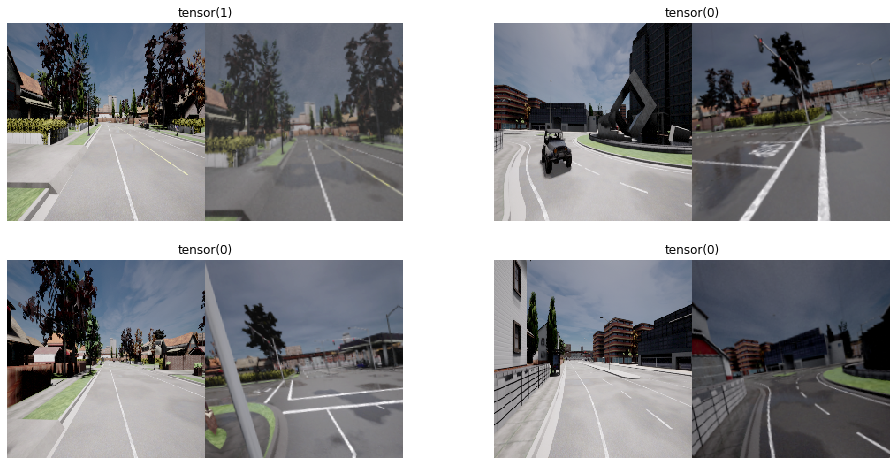

In [17]:
domain = "rainy_noon"
stats_static, stats_domain = train_ds.get_domain_stats(domain)
stats_static = torch.Tensor([stats_static[0][..., None, None], stats_static[1][..., None, None]])
stats_domain = torch.Tensor([stats_domain[0][..., None, None], stats_domain[1][..., None, None]])
plot_crossdomain_ex(train_ds, stats_static, stats_domain, rows=2, domain=domain)

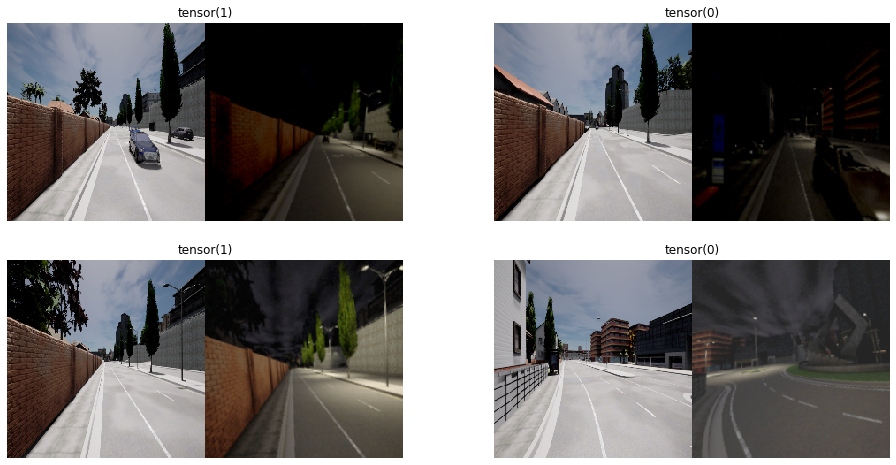

In [18]:
domain = "night"
stats_static, stats_domain = train_ds.get_domain_stats(domain)
stats_static = torch.Tensor([stats_static[0][..., None, None], stats_static[1][..., None, None]])
stats_domain = torch.Tensor([stats_domain[0][..., None, None], stats_domain[1][..., None, None]])
plot_crossdomain_ex(train_ds, stats_static, stats_domain, rows=2, domain=domain)

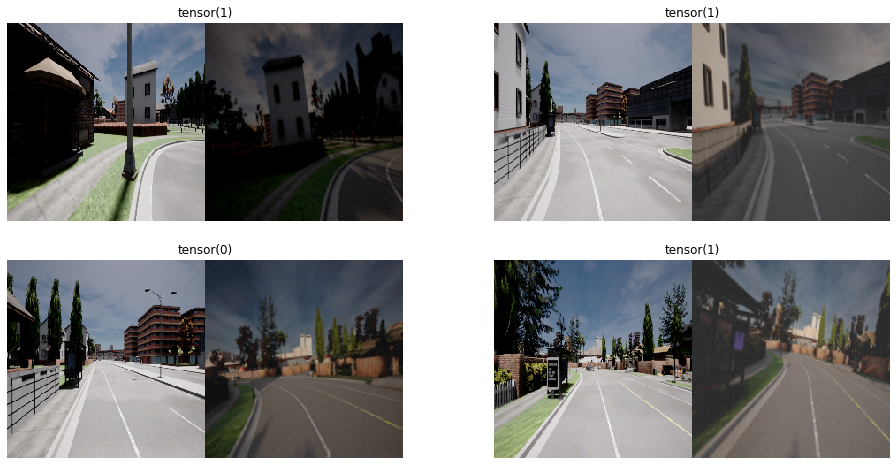

In [19]:
domain = "evening"
stats_static, stats_domain = train_ds.get_domain_stats(domain)
stats_static = torch.Tensor([stats_static[0][..., None, None], stats_static[1][..., None, None]])
stats_domain = torch.Tensor([stats_domain[0][..., None, None], stats_domain[1][..., None, None]])
plot_crossdomain_ex(train_ds, stats_static, stats_domain, rows=2, domain=domain)

# Model and training loop

In [46]:
gc.collect()
use_cuda = True
model = DynamicNet(data, ['night', 'evening', 'rainy_noon'])

Keys of dynamic extractors: dict_keys(['night', 'evening', 'rainy_noon'])


## Load model (uncomment when a model is available)

In [47]:
path_folder_model = os.path.join(path_models, 'multi-domain-test')
model.load(path_folder_model, flag_inference=True)

Loaded from data/saved/models/multi-domain-test sucessfully!


## Training and Saving

In [23]:
model.fit(max_lr=1e-3, epochs=5, continue_train=False)

### Saving

In [24]:
path_folder_model = os.path.join(path_models, 'multi-domain-test')

model.save(path_folder_model)

data/saved/models/multi-domain-test already exists. Delete it?(y/n)
y
Saved at data/saved/models/multi-domain-test successfully!


# Proof of Concept (for rotating training procedure)

In [ ]:
# import torch
# import torch.optim

In [ ]:
# day = torch.tensor([1.0, 2.0], requires_grad=True)
# night = torch.tensor([1.0, 2.0], requires_grad=True)
# evening = torch.tensor([1.0, 2.0], requires_grad=True)
# classifier = torch.tensor([5.0, 10.0], requires_grad=True)

In [ ]:
# opt_night = optim.SGD([night], lr=1)
# opt_evening = optim.SGD([evening], lr=1)
# opt_static = optim.SGD([day, classifier], lr=2)

In [ ]:
# opt_static.param_groups

[{'dampening': 0,
  'lr': 2,
  'momentum': 0,
  'nesterov': False,
  'params': [tensor([1., 2.], requires_grad=True),
   tensor([ 5., 10.], requires_grad=True)],
  'weight_decay': 0}]

In [ ]:
# day, night, evening, classifier

(tensor([1., 2.], requires_grad=True),
 tensor([1., 2.], requires_grad=True),
 tensor([1., 2.], requires_grad=True),
 tensor([ 5., 10.], requires_grad=True))

In [ ]:
# day.grad, night.grad, evening.grad, classifier.grad

(None, None, None, None)

In [ ]:
# Day and night pass 
# mul = day * night
# loss = (mul * classifier).sum()

In [ ]:
# loss.backward()

In [ ]:
# day.grad, night.grad, evening.grad, classifier.grad

(tensor([ 5., 20.]), tensor([ 5., 20.]), None, tensor([1., 4.]))

In [ ]:
# opt_night.step()

In [ ]:
# day, night, evening, classifier

(tensor([1., 2.], requires_grad=True),
 tensor([ -4., -18.], requires_grad=True),
 tensor([1., 2.], requires_grad=True),
 tensor([ 5., 10.], requires_grad=True))

In [ ]:
# day.grad, night.grad, evening.grad, classifier.grad

(tensor([ 5., 20.]), tensor([ 5., 20.]), None, tensor([1., 4.]))

In [ ]:
# Day and evening pass 
# mul = day * evening
# loss = (mul * classifier).sum()

In [ ]:
# loss.backward()

In [ ]:
# day.grad, night.grad, evening.grad, classifier.grad

(tensor([10., 40.]), tensor([ 5., 20.]), tensor([ 5., 20.]), tensor([2., 8.]))

In [ ]:
# opt_evening.step()

In [ ]:
# day, night, evening, classifier

(tensor([1., 2.], requires_grad=True),
 tensor([ -4., -18.], requires_grad=True),
 tensor([ -4., -18.], requires_grad=True),
 tensor([ 5., 10.], requires_grad=True))

In [ ]:
# day.grad.div_(2)
# classifier.grad.div_(2)

tensor([1., 4.])

In [ ]:
# opt_static.step()

In [ ]:
# day, night, evening, classifier

(tensor([ -9., -38.], requires_grad=True),
 tensor([ -4., -18.], requires_grad=True),
 tensor([ -4., -18.], requires_grad=True),
 tensor([3., 2.], requires_grad=True))

In [ ]:
# day.grad, night.grad, evening.grad, classifier.grad

(tensor([ 5., 20.]), tensor([ 5., 20.]), tensor([ 5., 20.]), tensor([1., 4.]))

In [ ]:
# opt_evening.zero_grad()
# opt_night.zero_grad()
# opt_static.zero_grad()

In [ ]:
# day.grad, night.grad, evening.grad, classifier.grad

(tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]))